# 1. 데이터 선정 이유 및 문제 정의
## 【통신사의 고객 데이터를 활용한 해지 예측】
- **데이터 선정 이유**: 실제 비즈니스에서 궁금해할만한 실용적인 사례라고 생각했기 때문입니다.   
- **문제 정의**: 통신사의 고객 데이터를 통해 고객의 해지를 예측하여 이탈을 사전에 막도록 합니다.
### 데이터 출처
- 캐글: https://www.kaggle.com/radmirzosimov/telecom-users-dataset
- 원본(Raw): https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113   
*(원본 출처에 컬럼 별 상세한 Description이 기재되어 있습니다.)*   

타겟은 `Churn` 이며 `True/False`로 구분되어 있는 **분류 문제**입니다.

# 2. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택

- **평가지표**: 타겟인 `Churn`이 `unbalaced`하기 때문에 `accuracy`와 함께 `roc_auc_score`를 평가지표로 한다
- **베이스라인**: 타겟의 최빈값

# 3. EDA와 데이터 전처리

In [1]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline

from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import roc_auc_score

import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Preview
df = pd.read_csv('telecom_users.csv', index_col=0)
df.head().T

,1869,4528,6344,6739,432
customerID,7010-BRBUU,9688-YGXVR,9286-DOJGF,6994-KERXL,2181-UAESM
gender,Male,Female,Female,Male,Male
SeniorCitizen,0,0,1,0,0
Partner,Yes,No,Yes,No,No
Dependents,Yes,No,No,No,No
tenure,72,44,38,4,2
PhoneService,Yes,Yes,Yes,Yes,Yes
MultipleLines,Yes,No,Yes,No,No
InternetService,No,Fiber optic,Fiber optic,DSL,DSL
OnlineSecurity,No internet service,No,No,No,Yes


In [3]:
# type이 제대로 되었는지 확인
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

`TotalCharges`가 숫자형인데 `object`로 되어있습니다. 타입을 맞춰주도록 하겠습니다.

In [4]:
# TotalCharges -> float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # 공백값 있음

`to_numeric` 함수를 쓰는데 에러가 나서 보니, 공백값이 있었습니다. 나중에 `Imputer`를 사용해주어야겠습니다.

고객의 인구통계학적 분포를 살펴보겠습니다.  
- gender: 성별    
- SeniorCitizen: 경로 대상 여부 (65세 이상)   
- Partner: 기혼 여부   
- Dependents: 피부양자가 있는지 (부모, 자녀 등)   

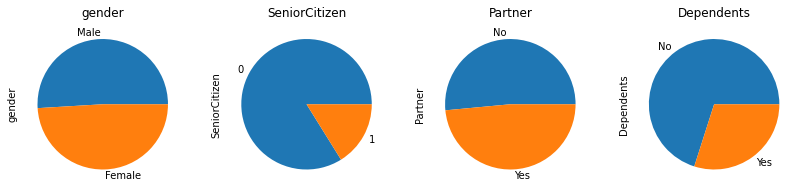

In [5]:
plt.rcParams["figure.figsize"] = (14,3)
fig, axs = plt.subplots(1, 4)
df['gender'].value_counts().plot.pie(ax=axs[0], title='gender')
df['SeniorCitizen'].value_counts().plot.pie(ax=axs[1], title='SeniorCitizen')
df['Partner'].value_counts().plot.pie(ax=axs[2], title='Partner')
df['Dependents'].value_counts().plot.pie(ax=axs[3], title='Dependents')
plt.show()

경로우대여부와 피부양자 유무는 unbalanced된 특성임을 참고합니다.   

다음은 숫자형 특성인 요금과 가입기간이 타겟에 어떻게 분포되어있는지 확인해보도록 하겠습니다.

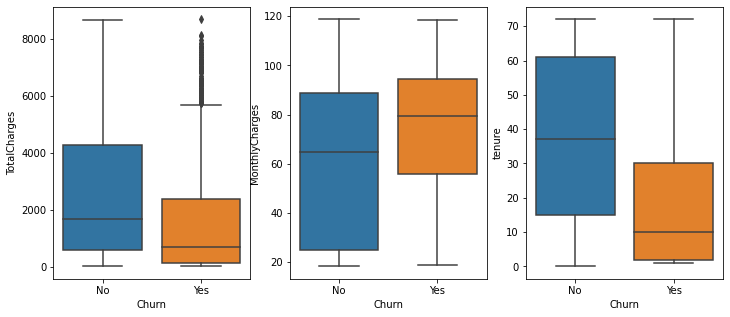

In [6]:
plt.rcParams["figure.figsize"] = (12,5)
fig, axs = plt.subplots(1, 3)
sns.boxplot(df.Churn, df.TotalCharges, ax=axs[0])
sns.boxplot(df.Churn, df.MonthlyCharges, ax=axs[1])
sns.boxplot(df.Churn, df.tenure, ax=axs[2])
plt.show()

여태까지 낸 돈(TotalCharges)이 적고,   
매달 나가는 비용(MonthlyCharges)이 높으며,   
사용한 기간(tenure)이 적을수록 해지한 사람들이 많다는 걸 알 수 있습니다.

타겟 자체의 비율이 unbalanced하기 때문에 `accuracy`와 함께 `roc_auc_score`를 사용하도록 하겠습니다.

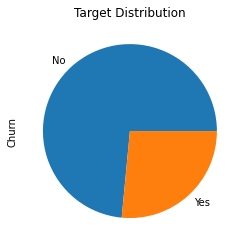

No     0.734881
Yes    0.265119
Name: Churn, dtype: float64

In [7]:
# Target Distribution
plt.rcParams["figure.figsize"] = (4,4)
df['Churn'].value_counts().plot.pie(title='Target Distribution')
plt.show()
df['Churn'].value_counts(normalize=True)

`customerID` 컬럼은 고유한 값이므로 제외하고, 타겟은 0, 1로 인코딩해줍니다.

In [8]:
def engineer(df):
    df = df.drop(columns='customerID')
    df['Churn'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

    return df

df = engineer(df)

마지막으로 데이터를 `train`과 `test` 세트로 나누고 `X/y`로 나눕니다.

In [9]:
train, test = train_test_split(df, random_state=0)
print('train set: ', train.shape)
print('test set: ', test.shape)

X_train, y_train = train.drop(columns='Churn'), train['Churn']
X_test, y_test = test.drop(columns='Churn'), test['Churn']

train set:  (4489, 20)
test set:  (1497, 20)


# 4. 머신러닝 방식 적용 및 교차검증

In [10]:
# Scoring
def print_score(model, name, on_test=False):
    if on_test:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        scores = model.score(X_test, y_test), roc_auc_score(y_test, y_pred_proba)
    else:
        scores_cv = cross_validate(model, X_train, y_train, cv=3, scoring=('accuracy', 'roc_auc'))
        scores = (scores_cv['test_accuracy'].mean(), scores_cv['test_roc_auc'].mean())
    print(f"{name} {'test_set' if on_test else 'CV mean score'}\n--------------------")
    print("accuracy:", scores[0])
    print("AUC:", scores[1])

## Baseline score

In [11]:
baseline_model = DummyClassifier()
baseline_model.fit(X_train, y_train)
print_score(baseline_model, "Baseline Model (Mode)")

Baseline Model (Mode) CV mean score
--------------------
accuracy: 0.7362441758144929
AUC: 0.5


## Decision Tree

In [12]:
pipe_dt = make_pipeline(OrdinalEncoder(), SimpleImputer(), DecisionTreeClassifier())
pipe_dt.fit(X_train, y_train)
print_score(pipe_dt, "Decision Tree")

Decision Tree CV mean score
--------------------
accuracy: 0.732680453003452
AUC: 0.6607354866965688


## Random Forest

In [13]:
pipe_rf = make_pipeline(OrdinalEncoder(), SimpleImputer(), RandomForestClassifier())
pipe_rf.fit(X_train, y_train)
print_score(pipe_rf, "Random Forest")

Random Forest CV mean score
--------------------
accuracy: 0.7903773976949741
AUC: 0.8213838020594859


## XGBoost

In [14]:
pipe_xgb = make_pipeline(OrdinalEncoder(), SimpleImputer(), XGBClassifier(verbosity=0))
pipe_xgb.fit(X_train, y_train)
print_score(pipe_xgb, "XGBoost")

XGBoost CV mean score
--------------------
accuracy: 0.7787961544003039
AUC: 0.8149570387434665


결과를 보면 Random Forest 방식이 별다른 튜닝 없이 좋은 스코어를 기록하고 있어 교차검증을 통한 파라미터 튜닝을 시도해보도록 하겠습니다.

## Random Forest를 이용한 교차검증과 하이퍼 파라미터 튜닝

In [15]:
grid = {
    'randomforestclassifier__n_estimators': range(200, 500, 50),
    'randomforestclassifier__max_depth': range(4, 8),
}

clf = GridSearchCV(pipe_rf, grid, n_jobs=-1, cv=3, scoring='roc_auc')
clf.fit(X_train, y_train)

pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,13,16,22,12,15,17,14,19,23,11,...,21,18,10,6,5,0,4,3,2,1
mean_fit_time,0.58344,0.820141,0.956775,0.437165,0.741019,0.924861,0.667548,0.547204,0.916217,0.908239,...,0.730713,0.448467,0.853718,0.431846,0.861696,0.453122,0.727721,0.732376,0.576126,0.518281
std_fit_time,0.058501,0.025704,0.009783,0.014018,0.03013,0.04453,0.069659,0.001695,0.009715,0.047826,...,0.004771,0.013683,0.070822,0.064176,0.066041,0.055244,0.04559,0.090449,0.048192,0.079305
mean_score_time,0.089428,0.090425,0.09242,0.052859,0.085771,0.119015,0.07347,0.066489,0.097415,0.08976,...,0.080452,0.055518,0.108044,0.055518,0.108709,0.051861,0.082446,0.088098,0.067486,0.054188
std_score_time,0.021795,0.00339,0.00463,0.001629,0.004232,0.015797,0.004772,0.003672,0.001232,0.00355,...,0.00094,0.001695,0.032331,0.009403,0.017522,0.003257,0.006532,0.013561,0.010116,0.00188
param_randomforestclassifier__max_depth,6,6,7,6,6,6,6,7,7,5,...,7,7,5,5,4,4,4,4,4,4
param_randomforestclassifier__n_estimators,250,400,400,200,350,450,300,250,450,450,...,350,200,400,200,450,200,400,350,300,250
params,"{'randomforestclassifier__max_depth': 6, 'rand...","{'randomforestclassifier__max_depth': 6, 'rand...","{'randomforestclassifier__max_depth': 7, 'rand...","{'randomforestclassifier__max_depth': 6, 'rand...","{'randomforestclassifier__max_depth': 6, 'rand...","{'randomforestclassifier__max_depth': 6, 'rand...","{'randomforestclassifier__max_depth': 6, 'rand...","{'randomforestclassifier__max_depth': 7, 'rand...","{'randomforestclassifier__max_depth': 7, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...",...,"{'randomforestclassifier__max_depth': 7, 'rand...","{'randomforestclassifier__max_depth': 7, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 4, 'rand...","{'randomforestclassifier__max_depth': 4, 'rand...","{'randomforestclassifier__max_depth': 4, 'rand...","{'randomforestclassifier__max_depth': 4, 'rand...","{'randomforestclassifier__max_depth': 4, 'rand...","{'randomforestclassifier__max_depth': 4, 'rand..."
split0_test_score,0.837152,0.836655,0.837039,0.835837,0.83673,0.836767,0.83599,0.836901,0.836914,0.83652,...,0.836053,0.836248,0.835376,0.834057,0.834449,0.834588,0.833578,0.834196,0.833482,0.833289
split1_test_score,0.854561,0.853711,0.852608,0.853271,0.853094,0.852704,0.852834,0.85234,0.851714,0.853077,...,0.853105,0.850744,0.852216,0.852239,0.851723,0.850953,0.851914,0.851012,0.851261,0.851907
split2_test_score,0.838577,0.838939,0.838236,0.838646,0.837828,0.83817,0.838692,0.838162,0.838732,0.837603,...,0.836535,0.837653,0.836811,0.837725,0.835495,0.836057,0.83521,0.835292,0.834867,0.834395


## 최종 테스트셋 스코어

In [16]:
best_model = clf.best_estimator_

print_score(best_model, "Random Forest Tuned", on_test=True)

Random Forest Tuned test_set
--------------------
accuracy: 0.7949231796927188
AUC: 0.8381256209144398


# 5. 머신러닝 모델 해석

## 특성별 평균 SHAP Value

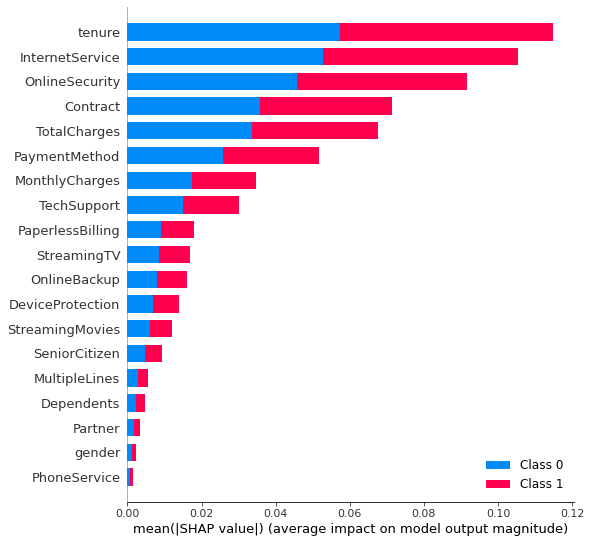

In [77]:
X_test_encoded = best_model[0].transform(X_test)
X_test_imputed = best_model[1].transform(X_test_encoded)
X_test_transformed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

explainer = shap.TreeExplainer(best_model.named_steps['randomforestclassifier'])

shap.initjs()
shap_values = explainer.shap_values(X_test_transformed[:100])
shap.summary_plot(shap_values, X_test_transformed[:100], plot_type='bar')

## False로 예측한 사례의 SHAP Plot

In [99]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_test_transformed.iloc[0, :100])

## True로 예측한 사례의 SHAP Plot

In [100]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][19, :], X_test_transformed.iloc[19, :100])